# EER Reflective Chatbot: Integrating Meeting Transcripts, Summaries, and Past Conversations

This notebook demonstrates the full setup for creating a Retrieval-Augmented Generation (RAG) chatbot designed to interact with meeting transcripts, summaries, and past conversation data. The chatbot's backend provides the following functionality:

### Features:
1. **Fetching Meeting Summaries**:
   - You can retrieve summaries of meetings, filtered by specific dates.

2. **Accessing RAG-Referenced Data**:
   - The chatbot can query and retrieve information from:
     - Meeting transcripts and related documents.
     - Data from previous chatbot conversations, enabling users to collaborate through the bot as a communication medium.

### Data Processing:
This notebook includes scripts for preprocessing and chunking the data that feeds into the chatbot. The input data consists of Zoom audio files processed through **Otter.ai**, which outputs transcripts in a specific format. 

As a result:
- **Preprocessing**: The scripts are tailored to handle Otter.ai's output format. This ensures that the raw data is cleaned, reformatted, and prepared for further processing.
- **Chunking**: The data is split into smaller, manageable chunks to optimize storage, retrieval, and querying within the vector store. The chunking logic is also dependent on Otter.ai's transcript structure.

### Setup Instructions:
- **Dependencies**: To ensure a smooth setup, it's recommended to create a virtual environment and install the required packages listed in `requirements.txt`. This will isolate the environment and ensure all necessary dependencies are correctly installed.
- **Customizability**: While this notebook is designed for Otter.ai's output, you can adapt the preprocessing scripts if your transcripts are generated using a different service or in another format.

This notebook provides a complete pipeline, from data preprocessing to chatbot integration, making it a starting point for building a RAG-based chatbot with advanced querying and conversational capabilities.

## Set API Keys and variables

To set up this chatbot environment, you need the following API keys:

1. **HuggingFace API Key**: This is required because both the LLM (Large Language Model) and the embeddings are hosted and served through HuggingFace. If you prefer to use a different API or service to host the LLM and generate embeddings, you would need to refactor specific parts of the code:
   - **LLM Configuration**: Update the instantiation of the LLM by replacing `llm = HuggingFaceHub(...)` with your preferred LLM hosting service or API.
   - **Embeddings**: Replace `HuggingFaceEmbeddings()` with the embedding generator from your chosen API or library. For instance, you could use OpenAI embeddings or a locally deployed model with libraries like `sentence-transformers`.

   These changes would affect all sections of the code where the LLM and embeddings are initialized or invoked.

2. **Pinecone API Key**: This is necessary to connect to the Pinecone vector store, where processed document vectors and chat history are stored and queried. Pinecone enables efficient semantic search by managing high-dimensional vector representations. However, if you prefer to use a different vector store (e.g., Weaviate, FAISS, or a custom database), you would need to:
   - Update the code that initializes and interacts with the Pinecone instance. For example, replace the `pc(api_key=...)` instantiation with the corresponding setup for your chosen vector store.
   - Modify all methods that query or upsert data into the vector store to align with the API or library of your chosen backend.

   For example:
   - To use FAISS, you would replace the Pinecone-specific logic with FAISS indexing and querying methods.
   - For local storage, you might implement a custom database schema and logic for embedding storage and retrieval.

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [75]:
HUGGINGFACE_API_KEY = os.environ.get("HUGGINGFACE_API_KEY", None)
PINECONE_API_KEY = os.environ.get("PINECONE_API_KEY_2", None)
repo_id = os.environ.get("REPO_ID", None)

## Data preprocessing

The first step is to process the data, as the formatting that Otter.ai provides is not fitting for working with. This script automates the reformatting process by taking raw transcript files from a specified folder and converting them into a structured, standardized format suitable for further analysis. Specifically, the script reads the input `.txt` files generated by Otter.ai.

It then reformats each file by:
1. **Extracting Key Information**: Identifying speaker names, timestamps, and the corresponding transcript text for each line.
2. **Handling Timestamp Variations**: Adjusting timestamp formats to ensure consistency (e.g., converting `mm:ss` to `hh:mm:ss`).
3. **Integrating Dates**: Combining the file's date (assumed to be embedded in the filename) with the timestamps to create complete datetime entries.
4. **Reformatting for Usability**: Organizing the data into a structured CSV format with clear columns for speaker name, datetime, and transcript text.

The script outputs these reformatted files into a designated folder, ensuring the data is clean, standardized, and ready for further processing steps.

In [31]:
# Loading libaries
import os
from datetime import datetime
import sys

In [34]:
# Define input and output folder paths
input_folder = "../data/otter-export-20241206_083341717279"
output_folder = "../data/reformatted_transcripts"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

In [32]:
# Define input and output folder paths
input_folder = "your/input/folder"
output_folder = "your/output/folder"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

In [35]:
# Function to process each file and reformat its content
def process_file(filename):
    """
    Processes a text file containing transcript data and reformats it into a structured CSV format.

    Args:
        filename (str): The name of the text file to process.

    Returns:
        list: A list of reformatted strings with each line containing speaker_name, date_time, and transcript_text.
    """
    # Open the file for reading and read all lines
    with open(os.path.join(input_folder, filename), 'r') as file:
        lines = file.readlines()

    reformatted_lines = []  # List to store reformatted lines
    for line in lines:
        # Split the line into parts using double spaces as the delimiter
        parts = line.strip().split('  ')
        if len(parts) == 2:
            name, timestamp = parts  # Extract the speaker name and timestamp
            date = filename[:10]  # Extract the date from the filename (assumes YYYY-MM-DD format)

            # Handle different timestamp formats
            time_parts = timestamp.split(':')
            if len(time_parts) == 2:
                # If the format is mm:ss, prepend "00:" to make it hh:mm:ss
                timestamp = f"00:{timestamp}"
            elif len(time_parts) == 3:
                # If the format is already hh:mm:ss, use it as-is
                timestamp = timestamp
            else:
                # Skip the line if the format is invalid
                continue

            try:
                # Combine the date and time, then reformat it
                timestamp_with_date = datetime.strptime(f"{date} {timestamp}", "%Y-%m-%d %H:%M:%S") \
                    .strftime("%a %b %d %H:%M:%S %Y %z")

                # Add the reformatted line to the list
                reformatted_lines.append(
                    f"{name};{timestamp_with_date};{lines[lines.index(line)+1].strip()}"
                )
            except ValueError:
                # Skip the line if timestamp parsing fails
                continue

    return reformatted_lines  # Return the list of reformatted lines

# Iterate over all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):  # Process only .txt files
        # Add a header row for the reformatted file
        header = "speaker_name;date_time;transcript_text"
        reformatted_lines = process_file(filename)
        reformatted_lines.insert(0, header)  # Insert the header at the top

        # Construct the output filename by appending "_rf.csv" to the original filename
        output_filename = os.path.splitext(filename)[0] + "_rf.csv"
        with open(os.path.join(output_folder, output_filename), 'w') as output_file:
            # Write the reformatted lines to the output file
            output_file.write("\n".join(reformatted_lines))

## Data chunking and Preparation for Vector Storage

Once the transcript data has been cleaned and reformatted, the next step is to prepare it for retrieval and querying. This involves splitting the transcript text into chunks and organizing it into a structured format called `docs`. These `docs` will later be upserted into a **vector store**.

#### Why is Data Chunking Necessary?

Long-form text, such as transcripts, can often be too unwieldy to work with directly. To optimize both the search and retrieval processes in a vector store, it's essential to split the text into smaller, meaningful chunks. These chunks serve several purposes:
1. **Improved Query Matching**: Smaller chunks make it easier to identify specific sections of text that are relevant to a user's query.
2. **Efficient Indexing**: By breaking down the text, the vector store can index and retrieve smaller pieces, reducing processing time.
3. **Context Preservation**: Careful chunking ensures that each piece of text remains coherent and meaningful, maintaining the necessary context for retrieval.

#### How the Data is Structured into Docs

The chunking process creates a list of objects, commonly referred to as `docs`. Each document in this list contains:
- **Content**: A chunk of text, which may represent a section of a transcript.
- **Metadata**: Additional information that describes the chunk, such as the speaker name, timestamp, and source file.

This structure enables the vector store to store not just the raw text but also contextual metadata, which enhances the accuracy and relevance of search results.

#### Preparing Data for the Vector Store

Here’s how the script accomplishes this:
1. **Splitting the Text**: The script uses a text splitter to divide the documents into chunks. Parameters like `chunk_size` and `chunk_overlap` are carefully configured to balance between size and context.
2. **Combining Data**: The chunks from PDF files, CSV files, or other sources are consolidated into a single collection of `docs`. This ensures all the data is in a unified format.
3. **Metadata Enrichment**: Metadata such as speaker names, timestamps, and file sources is attached to each chunk. This metadata plays an important role in search and retrieval.

**Keep in mind, that your vectorstore mighth have a limit to the batchsize allowed for upserting at once.**

## Summary pipeline
In addition to adding the meeting chunks to the vector store a summarization step is introduced to provide more insights and enhance the usability of the retrieved data. The summary pipeline involves:
1. **Text Analysis**: Summarization is performed using a Large Language Model (LLM) hosted on HuggingFace. The LLM processes each chunk or full transcript to generate concise, structured summaries.
2. **Speaker Attribution**: Unique speaker information is extracted from the transcript metadata and included in the summaries to maintain contextual relevance.
3. **Action Items and Decisions**: The LLM is instructed to identify and prioritize critical discussion points, decisions, and action items within the transcripts.

The summaries are then stored alongside the chunked data, allowing the interface to:
- Provide quick overviews for user queries.
- Surface relevant details without requiring users to parse lengthy transcripts.

### How the Data is Structured into Docs

The chunking process creates a list of objects, commonly referred to as docs. Each document in this list contains:
- **Content**: A chunk of text, which may represent a section of a transcript.
- **Metadata**: Additional information that describes the chunk, such as the speaker name, timestamp, and source file.
- **Summary**: A concise overview generated by the LLM, highlighting key discussion points.

This structure enables the vector store to store not just the raw text but also contextual metadata and summaries, enhancing the accuracy and relevance of search results.

### Preparing Data for the Vector Store

Here’s how the script accomplishes this:
1. **Splitting the Text**: The script uses a text splitter to divide the documents into chunks. Parameters like `chunk_size` and `chunk_overlap` are carefully configured to balance between size and context.
2. **Summarizing the Chunks**: Each chunk is passed to the LLM to generate a summary. These summaries provide a quick reference for the main ideas discussed in the transcripts.
3. **Combining Data**: The chunks from PDF files, CSV files, or other sources are consolidated into a single collection of docs. This ensures all the data is in a unified format.
4. **Metadata and Summary Enrichment**: Metadata such as speaker names, timestamps, file sources, and the generated summaries are attached to each chunk. This metadata plays an important role in both retrieval and user-facing responses.

In [4]:
# Loading libaries
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
import os
import pandas as pd

In [5]:
def datachunk(transcripts_folder=None, pdf_folder=None, single_file=None):
    """
    Load text documents from CSV and PDF files and split them into chunks.

    Args:
        transcripts_folder (str, optional): Path to the folder containing CSV files with transcripts.
        pdf_folder (str, optional): Path to the folder containing PDF files.
        single_file (str, optional): Path to a single file (CSV or PDF) to be loaded.

    Returns:
        list: A list of documents, where each document is either a chunked text 
              or an unprocessed document with metadata.
    """
    documents_csv = []
    documents_pdf = []

    if single_file:
        if single_file.endswith('.csv'):
            try:
                # Load the CSV file into a DataFrame
                transcripts_df = pd.read_csv(single_file, delimiter=';')
                for index, row in transcripts_df.iterrows():
                    # Create a document with content and metadata from the row
                    document = Document(
                        page_content=row["transcript_text"],
                        metadata={
                            "speaker_name": row["speaker_name"],
                            "date_time": row["date_time"],
                            "source": single_file
                        }
                    )
                    documents_csv.append(document)
                print(f"Single CSV file {single_file} loaded.")
            except FileNotFoundError:
                print(f"Error: The file {single_file} was not found.")
                return []
        elif single_file.endswith('.pdf'):
            try:
                # Use PyPDFLoader to extract content from the single PDF file
                loader = PyPDFLoader(single_file)
                documents_pdf.extend(loader.load())
                print(f"Single PDF file {single_file} loaded.")
            except FileNotFoundError:
                print(f"Error: The file {single_file} was not found.")
                return []
        else:
            print("Error: Unsupported file format. Please provide a CSV or PDF file.")
            return []
    else:
        # Get all CSV files in the transcripts folder
        csv_files = [file for file in os.listdir(transcripts_folder) if file.endswith('.csv')] if transcripts_folder else []
        # Get all PDF files in the PDF folder
        pdf_files = [file for file in os.listdir(pdf_folder) if file.endswith('.pdf')] if pdf_folder else []

        # Process CSV files
        for csv_file in csv_files:
            try:
                transcripts_df = pd.read_csv(os.path.join(transcripts_folder, csv_file), delimiter=';')
                for index, row in transcripts_df.iterrows():
                    document = Document(
                        page_content=row["transcript_text"],
                        metadata={
                            "speaker_name": row["speaker_name"],
                            "date_time": row["date_time"],
                            "source": csv_file
                        }
                    )
                    documents_csv.append(document)
            except FileNotFoundError:
                print(f"Error: The file {csv_file} was not found.")
                continue

        print("CSV files loaded...")

        # Process PDF files
        for pdf_file in pdf_files:
            loader = PyPDFLoader(os.path.join(pdf_folder, pdf_file))
            documents_pdf.extend(loader.load())

        print("PDF files loaded...")

    # Filter valid text documents
    text_documents = [doc for doc in documents_pdf if isinstance(doc, Document) and doc.page_content]

    # Initialize a text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=0,
        length_function=len
    )
    # Split text documents into smaller chunks
    split_docs = text_splitter.split_documents(text_documents)

    # Combine the split chunks with unprocessed PDF documents
    docs = split_docs + [doc for doc in documents_pdf if not isinstance(doc, Document)]
    # Add documents from the CSV files
    docs.extend(documents_csv)

    return docs


## Upserting docs to Pinecone Vectorstore

In [1]:
import os
from pinecone import Pinecone, ServerlessSpec
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import Pinecone as PineconeVectorStore
import pinecone

In [2]:
def initialize_vector_store(transcripts_folder=None, pdf_folder=None, single_file=None, index_name=None, pinecone_api_key=None, cloud="aws", region="us-east-1", metric="cosine", dimension=768):
    """
    Initializes a vector store by processing transcript and PDF data,
    creating a Pinecone index, and upserting the documents in batches.

    Args:
        transcripts_folder (str, optional): Path to the folder containing reformatted transcript files.
        pdf_folder (str, optional): Path to the folder containing PDF files.
        single_file (str, optional): Path to a single file (CSV or PDF) to be loaded.
        index_name (str): Name of the index to create in Pinecone.
        pinecone_api_key (str): API key for Pinecone.
        cloud (str, optional): Cloud provider for Pinecone (default is "aws").
        region (str, optional): Region for the Pinecone instance (default is "us-east-1").
        metric (str, optional): Metric for vector similarity (default is "cosine").
        dimension (int, optional): Dimensionality of the embeddings (default is 768).

    Returns:
        PineconeVectorStore: A PineconeVectorStore instance containing the upserted documents.
    """
    # Initialize HuggingFace embeddings
    embeddings = HuggingFaceEmbeddings()

    # Create a Pinecone instance
    pc = pinecone.Pinecone(api_key=pinecone_api_key)

    # Define the serverless specification
    spec = ServerlessSpec(cloud=cloud, region=region)

    # Process documents
    if single_file:
        print(f"Processing single file: {single_file}")
        docs = datachunk(single_file=single_file)
    else:
        print(f"Processing folders - Transcripts: {transcripts_folder}, PDFs: {pdf_folder}")
        docs = datachunk(transcripts_folder=transcripts_folder, pdf_folder=pdf_folder)

    print(f"Total number of documents: {len(docs)}")

    # Check if the index exists; if not, create it
    if index_name not in [index['name'] for index in pc.list_indexes()]:
        # Create the index
        pc.create_index(name=index_name, dimension=dimension, metric=metric, spec=spec)
        # Connect to the index
        index = pc.Index(index_name)
        # Upsert documents in batches
        for i, doc in enumerate(docs):
            doc_id = f'doc_{i}'
            embedding_vector = embeddings.embed_documents([doc.page_content])[0]
            metadata = doc.metadata.copy()
            metadata['page_content'] = doc.page_content
            vector = (doc_id, embedding_vector, metadata)
            index.upsert(vectors=[vector])
        print("Created new Pinecone index and loaded documents.")
    else:
        print(f"Loading into existing Pinecone index: {index_name}")
        # Connect to the index
        index = pc.Index(index_name)
        # Upsert documents in batches
        for i, doc in enumerate(docs):
            doc_id = f'doc_{i}_2024'
            embedding_vector = embeddings.embed_documents([doc.page_content])[0]
            metadata = doc.metadata.copy()
            metadata['page_content'] = doc.page_content
            vector = (doc_id, embedding_vector, metadata)
            index.upsert(vectors=[vector])
        print("Loaded Pinecone index and loaded documents.")
        
    return docs

In [ ]:
# Example usage
# Load a Single File:
initialize_vector_store(
    single_file="../data/sample.csv",
    index_name="index_name",
    pinecone_api_key=os.getenv("PINECONE_API_KEY")
)

# Load Entire Folders:
initialize_vector_store(
    transcripts_folder="../data/transcripts_folder",
    pdf_folder="../data/pdf_folder",
    index_name="index_name",
    pinecone_api_key=os.getenv("PINECONE_API_KEY")
)

In [ ]:
# Load Entire Folders:
initialize_vector_store(
    transcripts_folder="../data/reformatted_transcripts",
    pdf_folder="../data/EER-site-pages-pdf",
    index_name="eer-pdfs-transcripts",
    pinecone_api_key=os.getenv("PINECONE_API_KEY_2")
)

c:\Users\szh\Desktop\EER\EER-chatbot-UI\.venv\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Processing folders - Transcripts: ../data/reformatted_transcripts, PDFs: ../data/EER-site-pages-pdf
CSV files loaded...
PDF files loaded...
Total number of documents: 10290


## Generating summaries, and adding them to vector store

In [2]:
import os
import pandas as pd
from datetime import datetime
import time
import re
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint as HuggingFaceHub
from langchain_community.vectorstores.pinecone import Pinecone
from pinecone import Pinecone as pc
import pinecone

load_dotenv()

True

In [3]:
class TranscriptProcessor:
    def __init__(self, model_repo="meta-llama/Llama-3.1-70B-Instruct", temperature=1.0, api_token=None):
        self.llm = HuggingFaceHub(
            repo_id=model_repo,
            temperature=temperature,
            huggingfacehub_api_token=api_token or os.getenv('HUGGINGFACE_API_KEY')
        )
        self.embeddings = HuggingFaceEmbeddings()
        self.pinecone_instance_chat = pc(api_key=os.getenv('PINECONE_API_KEY_2'), embeddings=self.embeddings)
    
    def summary_prompt(self, text):
        return f"Please identify the main discussion points, decisions, and action items from my meeting notes below and provide a concise bulleted summary. Here is the meeting transcript: '{text}'. Your notes and summary:"
    
    def extract_unique_speakers(self, file):
        """Extract unique speakers from an uploaded CSV file."""
        try:
            df = pd.read_csv(file, delimiter=";")
            unique_speakers = df['speaker_name'].unique().tolist()
            return unique_speakers
        except Exception as e:
            print(f"Error extracting speakers from file: {e}")
            return []
    
    def load_csv_content(self, file):
        """Load the content of the uploaded CSV file for summarization."""
        try:
            file.seek(0)  # Ensure the file pointer is at the beginning
            return file.read()  # No need to decode, just read the content
        except Exception as e:
            print(f"Error loading file content: {e}")
            return ""

    def process_transcripts(self, files):
        """Process a single uploaded file or multiple uploaded files and return a dictionary of transcript data."""
        transcript_data = {}

        if isinstance(files, list):
            print(f"Processing {len(files)} files...")
            for idx, file in enumerate(files, start=1):
                if file.name.endswith('.csv'):
                    print(f"Processing file {idx}/{len(files)}: {file.name}")
                    speakers = self.extract_unique_speakers(file)
                    transcript_text = self.load_csv_content(file)
                    print(f"Extracted speakers: {speakers}")
                    
                    summary = self.llm.invoke(self.summary_prompt(transcript_text))
                    print(f"Generated summary for {file.name}:\n{summary}\n")
                    
                    transcript_data[file.name] = {
                        "speakers": speakers,
                        "summary": summary
                    }
                else:
                    print(f"Skipping non-CSV file: {file.name}")
        else:
            print("Processing a single file...")
            if files.name.endswith('.csv'):
                print(f"Processing file: {files.name}")
                speakers = self.extract_unique_speakers(files)
                transcript_text = self.load_csv_content(files)
                print(f"Extracted speakers: {speakers}")
                
                summary = self.llm.invoke(self.summary_prompt(transcript_text))
                print(f"Generated summary for {files.name}:\n{summary}\n")
                
                transcript_data[files.name] = {
                    "speakers": speakers,
                    "summary": summary
                }
            else:
                print(f"Skipping non-CSV file: {files.name}")

        print("Processing completed.")
        return transcript_data


    def upsert_summaries_to_pinecone(self, data):
        """Upsert processed summaries to Pinecone."""
        index_name = "eer-meetings-summaries"
        environment = "gcp-starter"
        index = self.pinecone_instance_chat.Index(index_name, environment=environment)

        for i, (meeting_id, meeting_data) in enumerate(data.items(), start=1):
            summary = meeting_data['summary']
            speakers = meeting_data['speakers']

            # Create embedding for the summary
            embedding = self.embeddings.embed_documents([summary])[0]

            # Use regex to find the date at the beginning of the filename
            match = re.search(r"(\d{4}-\d{2}-\d{2})", meeting_id)
            if match:
                date_str = match.group(1)
                try:
                    dt_obj = datetime.strptime(date_str, "%Y-%m-%d")
                    unix_timestamp = int(time.mktime(dt_obj.timetuple()))
                except ValueError as e:
                    print(f"Error parsing date from filename '{meeting_id}': {e}")
                    continue
            else:
                print(f"No valid date found in filename '{meeting_id}'")
                continue

            # Upsert to Pinecone
            index.upsert(vectors=[
                {
                    'id': f"{unix_timestamp}",
                    'values': embedding,
                    'metadata': {
                        "date": date_str,
                        "summary": summary,
                        "speakers": speakers,
                        "date_unix": unix_timestamp,
                        "text": summary,
                        "meeting_number": i
                    }
                }
            ])

In [ ]:
# Define the path to the directory containing transcript files
file_path = "your/file/path"

# List all .csv files in the directory
files = [
    open(os.path.join(file_path, file), 'r') 
    for file in os.listdir(file_path) 
    if file.endswith('.csv')
]

# Initialize the TranscriptProcessor
processor = TranscriptProcessor()

# Process the transcript files and generate summaries
summaries = processor.process_transcripts(files)
print(f"Processed {len(summaries)} files.")

# Upsert to Pinecone
processor.upsert_summaries_to_pinecone(summaries)
print(f"Succesfully upserted {len(summaries)} summaries to Pinecone.")

## Setting up chatbot with RAG and integration of previous conversations

This code defines a **Chatbot** class designed for integrating document retrieval, interaction with a Large Language Model (LLM), and maintaining chat history. It is part of a setup to assist with data exploration and reflective conversations in the **Experimenting Experiencing Reflecting (EER)** project. Below is a detailed description of each major component:


### **Class: `Chatbot`**
This class orchestrates the various components required to run the chatbot.

#### Attributes:
- **`temperature`**: Controls randomness in LLM responses (higher = more creative, lower = more deterministic).
- **`user_name`**: Tracks the name of the user interacting with the chatbot.
- **`session_id`**: A unique identifier for each chat session, used for logging and metadata.
- **`embeddings`**: Generates vector representations of text data for storage and retrieval.
- **`llm`**: Handles interactions with a hosted LLM for generating responses to user queries.

---

### **Initialization (`__init__`)**

This method initializes the chatbot by:
1. **Loading Environment Variables**:
   - Loads API keys for HuggingFace and Pinecone from a `.env` file for security and flexibility.
2. **Setting Up Embeddings**:
   - Instantiates `HuggingFaceEmbeddings`, which are used to embed text data for vector storage and semantic querying.
3. **Configuring Pinecone**:
   - Initializes a Pinecone instance for vector storage with the API key.
   - Assigns the `eer-transcripts-pdfs` index for storing and querying document embeddings.
4. **Configuring the LLM**:
   - Uses the `HuggingFaceHub` integration to connect to a specific model (`repo_id`) hosted on HuggingFace.
   - Sets hyperparameters like `temperature`, `top_p`, and `top_k` for controlling the LLM's response generation.

---

### **Methods**

#### **`default_prompt_sourcedata`**
Generates a prompt for querying source documents, integrating:
- **Chat History**: To maintain context.
- **Relevant Data**: Data retrieved from the vector store based on the user's query.
- **User Input and Name**: Personalizes the response.

#### **`default_prompt_conv`**
Creates a prompt to retrieve and summarize past conversations relevant to the user's query. This method:
- References the LLM's latest response.
- Summarizes past conversations stored in the vector store.
- Uses the user’s name for personalization and traceability.

#### **`retrieve_docs`**
Retrieves documents from the vector store (Pinecone) by:
- Using the `input` query to search for relevant embeddings.
- Filtering results based on session ID (if specified) to avoid redundant or irrelevant data.
- Limiting the number of results (`k`).

**Error Handling**:
Logs retrieval errors for debugging and ensures the program can gracefully handle such issues.

#### **`invoke_llm_with_retry`**
Adds retry logic to LLM invocations using `tenacity`:
- Retries up to 5 times with a 2-second interval if a transient error occurs (e.g., connection issues).

#### **`get_llm_response`**
Wraps the LLM call, returning the response or an error message if all retry attempts fail.

#### **`upsert_vectorstore`**
Stores the current conversation (user input and LLM output) in the Pinecone vector store with metadata:
- Embeds the concatenated user input and AI output using the configured embedding generator.
- Metadata includes:
  - User question and AI response.
  - Timestamp of the interaction.
  - User name and session ID for traceability.

---

### **Customization**
- **Alternate Vector Store**: Replace Pinecone with FAISS or another vector storage library by refactoring `retrieve_docs` and `upsert_vectorstore`.
- **Local LLM**: Swap HuggingFaceHub for a locally deployed LLM by modifying `llm` initialization.
- **Prompt Engineering**: Tailor prompts in `default_prompt_sourcedata` and `default_prompt_conv` to align with specific chatbot use cases.

In [ ]:
import os
from datetime import datetime, timezone
import logging
from tenacity import retry, stop_after_attempt, wait_fixed
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint as HuggingFaceHub
from langchain_community.vectorstores.pinecone import Pinecone
from pinecone import Pinecone as pc
import pinecone

In [ ]:
# Set up logging for the chatbot
logger = logging.getLogger(__name__)

# The chatbot class definition with methods for RAG-based document retrieval and LLM-based conversation generation
class chatbot:
    """
    A chatbot class that interacts with the Experimenting Experiencing Reflecting (EER) project data, including document retrieval, LLM integration, and storing chat history.

    Attributes:
        temperature (float): The temperature parameter for the language model.
        user_name (str): The name of the user interacting with the chatbot.
        session_id (str): A unique identifier for the user's session.
        embeddings (HuggingFaceEmbeddings): Embedding generator for document vectors.
        llm (HuggingFaceHub): HuggingFace language model endpoint.
    """

    def __init__(self, temperature=0.8, prompt_sourcedata=None, prompt_conv=None, user_name=None, session_id=None):
        """
        Initializes the chatbot instance with parameters and sets up embeddings and LLM.

        Args:
            temperature (float, optional): Temperature for controlling randomness in LLM outputs. Defaults to 0.8.
            prompt_sourcedata (str, optional): Prompt template for source data queries.
            prompt_conv (str, optional): Prompt template for conversational context.
            user_name (str, optional): Name of the user.
            session_id (str, optional): Unique session identifier.
        """
        load_dotenv()
        self.embeddings = HuggingFaceEmbeddings()
        self.index_name = "eer-transcripts-pdfs"
        self.pinecone_instance = pc(api_key=os.getenv('PINECONE_API_KEY_2'), embeddings=self.embeddings)

        # Self-assign parameters
        self.user_name = user_name
        self.session_id = session_id
        self.temperature = temperature

        # Instantiate the LLM
        self.llm = HuggingFaceHub(
            repo_id=os.getenv('repo_id'),
            temperature=temperature,
            top_p=0.8,
            top_k=50,
            huggingfacehub_api_token=os.getenv('HUGGINGFACE_API_KEY')
        )
        self.prompt_sourcedata = prompt_sourcedata
        self.prompt_conv = prompt_conv

    def default_prompt_sourcedata(self, chat_history, original_data, user_input, user_name):
        """
        Generates the default prompt for sourced data queries.

        Args:
            chat_history (str): The chat history so far.
            original_data (str): The relevant data retrieved from the database.
            user_input (str): The user's query.
            user_name (str): The name of the user.

        Returns:
            str: The formatted prompt for sourced data queries.
        """
        return f"""You are a chatbot assistant, working for the Experimenting Experiencing Reflecting (EER) Project, a research endeavor investigating the connections between art and science.
    You have access to a collection of documents, including descriptions of research activities, meeting transcripts, and other relevant materials. Your main task is to help the user explore and reflect on the EER project. When possible, please cite source documents in your answer (calling the documents the transcript date, e.g. "2021-05-28", or website page after the "/"). 
    You are now assisting the user "{user_name}" with their query: "{user_input}". Below is the relevant data from the EER group that was retrieved from the database for this query: "{original_data}". Based on this data, provide a concise answer to the user’s question in maximum 2 paragraphs. The previous chat history for this session so far is: {chat_history} Your response:"""

    def default_prompt_conv(self, chat_history, user_input, llm_response, past_chat, user_name):
        """
        Generates the default prompt for conversation context queries.

        Args:
            chat_history (str): The chat history so far.
            user_input (str): The user's query.
            llm_response (str): The response from the LLM.
            past_chat (str): Relevant data from past conversations.
            user_name (str): The name of the user.

        Returns:
            str: The formatted prompt for conversation context queries.
        """
        return f"""You are an assistant observing conversations between the user and another LLM regarding meeting transcripts and content from the Experimenting Experiencing Reflecting (EER) Project, a research group investigating the connections between art and science.
    All interactions between people and the LLM are recorded and stored in your database. When people ask questions about the data, you get the question and the answer from the LLM. You use that data to search your database of past conversations for conversations that might be related. You will create a summary of those past conversations no longer than 4 sentences. Your summary should mention the name of the person involved in the past conversations, so that if the user wants to, they can follow up with them.
    Here is the last question asked by the user in this session: "{user_name}" asked: {user_input}
    Here is what the LLM you are watching responded with: “{llm_response}”
    Here is relevant data from past conversations that is relevant: {past_chat}
    Here is the chat history for this session, so that your response can be aware of the context: {chat_history}
    Your response: """

    def retrieve_docs(self, input, index, excluded_session_id=None, k=5):
        """
        Retrieves documents from a Pinecone index, optionally excluding a specific session ID.

        Args:
            input (str): The input query for retrieving documents.
            index (str): The name of the Pinecone index to retrieve documents from.
            excluded_session_id (str, optional): Session ID to exclude from retrieval (for avoiding duplicate data).
            k (int, optional): The number of documents to retrieve. Defaults to 5.

        Returns:
            list: A list of retrieved documents.
        """
        try:
            docsearch = Pinecone.from_existing_index(index, self.embeddings)

            if index == "eer-interaction-data":
                search_kwargs = {
                    "k": k,
                    "filter": {
                        "session_id": {"$ne": excluded_session_id}
                    }
                }
            else:
                search_kwargs = {"k": k}

            retriever = docsearch.as_retriever(search_kwargs=search_kwargs)
            docs = retriever.invoke(input)
            return docs
        except Exception as e:
            logger.error("Error retrieving documents: %s", e)
            raise

    @retry(stop=stop_after_attempt(5), wait=wait_fixed(2))
    def invoke_llm_with_retry(self, prompt):
        """
        Invokes the LLM with retry logic to handle transient connection issues.

        Args:
            prompt (str): The prompt to send to the LLM.

        Returns:
            str: The LLM's response to the prompt.
        """
        response = self.llm.invoke(prompt)
        return response

    def get_llm_response(self, prompt):
        """
        Generates a response from the LLM, retrying if necessary.

        Args:
            prompt (str): The prompt to send to the LLM.

        Returns:
            str: The LLM's response or an error message if the invocation fails.
        """
        try:
            response = self.invoke_llm_with_retry(prompt)
            return response
        except Exception as e:
            error = f"Error invoking LLM: {e}"
            return error

    def format_context(self, documents, chat=False):
        """
        Formats the context from retrieved documents for use in prompts.

        Args:
            documents (list): List of documents retrieved from Pinecone.
            chat (bool, optional): Whether to format as chat context. Defaults to False.

        Returns:
            str: A formatted string representing the context.
        """
        context = ""

        for idx, doc in enumerate(documents, start=1):
            metadata = doc.metadata
            if chat:
                context += (
                    f'User {idx}: {metadata.get("user_name", "Unknown User")}\n'
                    f'Chat session {idx}: {metadata.get("session_id", "Unknown Session ID")}\n'
                    f'User Question: "{metadata.get("user_question", "Unknown Question")}"\n'
                    f'AI Response: "{metadata.get("ai_output", "Unknown Response")}"\n'
                    f"Date: {metadata.get('date', 'Unknown Date')}\n\n"
                )
            else:
                if metadata.get("page") is not None:
                    context += (
                        f"Document type: PDF {idx}\n"
                        f"Page content: {doc.page_content}\n"
                        f"Source: {metadata['source']}\n"
                        f"Page: {metadata['page']}\n"
                    )
                else:
                    context += (
                        f"Document type: Meeting Transcript Exerpt {idx}\n"
                        f"Person {idx}: {metadata.get('speaker_name', 'Unknown Speaker')}\n"
                        f"Date: {metadata.get('date_time', 'Unknown Date')}\n"
                        f"Content: {doc.page_content}\n\n"
                    )

        return context

    def upsert_vectorstore(self, user_input, ai_output, user_name, session_id):
        """
        Upserts the conversation data to the Pinecone vector store, storing user input, AI output, and metadata.

        Args:
            user_input (str): The user's input.
            ai_output (str): The AI's response.
            user_name (str): The name of the user.
            session_id (str): The unique session identifier.
        """
        try:
            pinecone_instance_chat = pc(api_key=os.getenv('PINECONE_API_KEY'), embeddings=self.embeddings)
            index_name = "eer-interaction-data"
            environment = "gcp-starter"
            index = pinecone_instance_chat.Index(index_name, environment=environment)

            embedding = self.embeddings.embed_documents([user_input + ai_output])[0]

            index.upsert(vectors=[
                {
                    'id': session_id,
                    'values': embedding,
                    'metadata': {
                        "user_question": user_input,
                        "ai_output": ai_output,
                        "user_name": user_name,
                        "session_id": session_id,
                        "date": datetime.now(timezone.utc).isoformat(),
                        "text": f"User input: {user_input}, AI output: {ai_output}"
                    }
                }
            ])
            logger.info("Upsert to Pinecone successful for session_id: %s", session_id)
        except Exception as e:
            logger.error("Error upserting to Pinecone: %s", e)
            raise

    def pipeline(self, user_input, user_name, session_id, chat_history=None):
        """
        Handles the full pipeline of receiving user input, generating responses, and storing data.

        Args:
            user_input (str): The user's input.
            user_name (str): The name of the user.
            session_id (str): The unique session identifier.
            chat_history (str, optional): The chat history for context. Defaults to None.

        Returns:
            dict: A dictionary containing the AI output, source data, and past chat context.
        """
        if chat_history:
            chat_history = chat_history + "\n\n"
        else:
            chat_history = ""

        # Step 1: Retrieve source data
        source_data = self.retrieve_docs(user_input, "eer-transcripts-pdfs")
        formatted_source_data = self.format_context(source_data)

        # Step 2: Generate LLM response from source data
        sourcedata_response = self.get_llm_response(self.default_prompt_sourcedata(chat_history=chat_history, original_data=formatted_source_data, user_input=user_input, user_name=user_name))

        # Step 3: Retrieve past chat context
        past_chat_context = self.retrieve_docs(sourcedata_response, "eer-interaction-data", session_id)
        formatted_chat_context = self.format_context(past_chat_context, chat=True)

        # Step 4: Generate LLM response for conversation context, now considering combined chat history
        conversation_response = self.get_llm_response(self.default_prompt_conv(chat_history=chat_history, user_input=user_input, llm_response=sourcedata_response, past_chat=formatted_chat_context, user_name=user_name))

        # Step 5: Combine the responses
        ai_output = f"{sourcedata_response}\n\n{conversation_response}"
        logger.info(f"Pipeline generated response: {ai_output}")

        # Step 6: Upsert to vector store
        self.upsert_vectorstore(user_input, ai_output, user_name, session_id)

        # Return a dictionary containing all relevant information
        return {
            "ai_output": ai_output,
            "source_data": source_data,
            "past_chat_context": past_chat_context
        }
        
    @staticmethod
    def query_summaries(timestamp):
        # Set up pinecone client
        pineclient = pinecone.Pinecone(api_key=os.environ.get("PINECONE_API_KEY_2"))
        
        # Connect to the index
        index_name = "eer-meetings-summaries"
        index = pineclient.Index(index_name)
        
        # Example vector query (should be replaced with actual vector for filtering)
        query_vector = [1] * 768  # Replace with meaningful vector logic
        
        # Query the index
        results = index.query(
            vector=query_vector,
            top_k=100,
            include_metadata=True
        )
        
        results_dict = results.to_dict()
        
        for match in results_dict["matches"]:
            if match["metadata"]["date"] == timestamp:
                return match["metadata"]
        return "No match found"

## Streamlit Interface

The code for the Streamlit interface is provided below and must be run as a `.py` script by executing the command:

```bash
streamlit run src/streamlit_rag_chatbot.py
```

Before running the application, ensure that:
1. **Streamlit is Installed**: You can install it via pip if it's not already installed:
   ```bash
   pip install streamlit
   ```
2. **Dependencies are Installed**: All required packages must be installed using the `requirements.txt` file:
   ```bash
   pip install -r requirements.txt
   ```

### Streamlit Application Overview
The Streamlit application serves as the user interface for the RAG (Retrieval-Augmented Generation) chatbot. It provides a clean and interactive platform where users can:
- Query meeting transcripts and summaries from the **Experimenting Experiencing Reflecting (EER)** project.
- Receive responses from a chatbot powered by a Large Language Model (LLM) that integrates source data and contextual conversation history.
- Explore referenced data and previous conversations stored in a vector database.

### How the Streamlit Application Works
1. **Backend Integration**:
   - The Streamlit app communicates with the chatbot backend, which processes user inputs, retrieves relevant data, and generates responses.
   - The backend uses vector embeddings to match queries with meeting transcripts, summaries, and past interactions.

2. **Key Features**:
   - **Meeting Summary Fetching**: Users can select a date to retrieve and display summaries of past meetings.
   - **Chat Interface**: A conversational interface allows users to ask questions about the EER project, with the chatbot responding in real time.
   - **Referenced Data Display**: The app includes expandable sections where users can view detailed references to documents and transcripts mentioned in the chatbot's responses.
   - **Session Management**: The app tracks chat history and user sessions, ensuring continuity and context in conversations.

3. **How It Runs**:
   - The application initializes the chatbot when the app starts and prompts users to provide their name to personalize the interaction.
   - It stores all interactions, including user inputs and AI responses, for context-aware querying and insights into past questions..

In [ ]:
import streamlit as st
import logging  # Import logging
from langchain_community.chat_message_histories import StreamlitChatMessageHistory
import uuid
from main import chatbot
import streamlit_nested_layout

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    handlers=[
        logging.FileHandler("chatbot_log.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

st.set_page_config(page_title="EER Transcript Explorer Bot", layout="wide")

# Initialize chat history if not present
if "messages" not in st.session_state:
    st.session_state.messages = [{"role": "assistant", "content": "Hi, how can I help you today?"}]
if "first_question" not in st.session_state:
    st.session_state.first_question = ""

# Functiion to initialize the chatbot
def initialize_bot():
    try:
        if "bot" not in st.session_state or st.session_state.bot is None:
            st.session_state.bot = chatbot()
    except Exception as e:
        st.error(f"Error initializing bot: {e}")
        logger.error(f"Error initializing bot: {e}")

initialize_bot()

# Setting up the session state variables
if "chat_data" not in st.session_state:
    st.session_state.chat_data = []

if "user_name" not in st.session_state:
    st.session_state.user_name = None

if "session_id" not in st.session_state:
    st.session_state.session_id = str(uuid.uuid4())

if "history" not in st.session_state:
    st.session_state.history = StreamlitChatMessageHistory()

# Function to ask the user for their name
@st.dialog("Please enter your name:", width="small")
def ask_name():
    user_name = st.text_input(label="Name", label_visibility="collapsed", placeholder="Your name")
    if st.button("Submit"):
        if user_name:
            st.session_state.user_name = user_name
            logger.info(f"User name set to: {user_name}")
            st.rerun()

if st.session_state.user_name is None:
    ask_name()

# Function to generate a response from the AI
def generate_response(input_text):
    bot = st.session_state.get("bot")
    chat_history = "\n".join([
        f"User: {msg.get('input_text', '')}\nAI: {msg.get('ai_output', '')}"
        for msg in st.session_state.chat_data
        if msg.get('type') == 'ai' or msg.get('type') == 'user'
    ])
    try:
        result = bot.pipeline(user_input=input_text, user_name=st.session_state.user_name, session_id=st.session_state.session_id, chat_history=chat_history)
        logger.info(f"AI Response: {result.get('ai_output', 'No answer generated')}")
        return result
    except Exception as e:
        st.error(f"Error generating response: {e}")
        logger.error(f"Error generating response: {e}")
        return {}
  
def query_meeting_summary(datestamp):
    
    bot = st.session_state.get("bot")
    
    # Query summaries from the bot
    result = bot.query_summaries(datestamp)

    # Extract details safely from metadata
    date = result.get("date", "Unknown date")
    speakers_list = result.get("speakers", [])
    summary = result.get("summary", "No summary available")

    # Construct speaker string
    if isinstance(speakers_list, list) and len(speakers_list) > 1:
        speakers = ' and '.join([', '.join(speakers_list[:-1]), speakers_list[-1]])
    else:
        speakers = speakers_list[0] if speakers_list else "No speakers listed"

    # Construct and return the output
    return (
        f"**Meeting date:** {date}.\n\n"
        f"**Speaker list:** {speakers}.\n\n"
        f"**Meeting summary:** {summary}"
    )



st.title(f"🤖 EER Transcript Explorer Bot")
st.write("""
    This is a chatbot with access to meeting transcripts from the EER project (May 2021 - December 2024) and relevant project documents. The first part of the chatbot's answer to your question refers to the transcripts and other source data. The second part describes connections between your question and questions other people have asked about the data. Perhaps you'll learn that someone else is curious about similar things. Please note that all interactions are stored in a database and will be visible to other users.
""")

with st.expander("Fetch a meeting summary", expanded=False):
    #datestamp = st.date_input("Meeting summary date", datetime.date(2024, 1, 30))
    
    datestamp = st.selectbox(
        "Select a date to fetch the meeting summary",
        ("2024-12-10","2024-11-24", "2024-11-19", "2024-11-12", "2024-10-29", "2024-10-24",
         "2024-10-15", "2024-10-01", "2024-09-24", "2024-09-17", "2024-09-10",
        "2024-08-22", "2024-08-15", "2024-08-06", "2024-06-25", "2024-06-11",
        "2024-05-28", "2024-05-21", "2024-05-07", "2024-04-30", "2024-04-23",
        "2024-04-09", "2024-03-26", "2024-03-19", "2024-03-12", "2024-03-05",
        "2024-02-27", "2024-01-30", "2024-01-25", "2024-01-24", "2024-01-18",
        "2024-01-11", "2023-12-07", "2023-11-30", "2023-11-23", "2023-10-19",
        "2023-10-05", "2023-09-28", "2023-09-21", "2023-08-31", "2023-08-24",
        "2023-08-17", "2023-08-10", "2023-06-29", "2023-06-22", "2023-06-15",
        "2023-06-08", "2023-06-01", "2023-05-25", "2023-05-04", "2023-04-27",
        "2023-04-20", "2023-04-13", "2023-03-23", "2023-03-16", "2023-02-02",
        "2023-01-19", "2023-01-05", "2022-12-16", "2022-12-08", "2022-12-01",
        "2022-11-24", "2022-11-17", "2022-11-10", "2022-10-20", "2022-10-13",
        "2022-09-29", "2022-09-08", "2022-09-01", "2022-08-25", "2022-06-30",
        "2022-05-05", "2022-04-21", "2022-04-11", "2022-03-24", "2022-03-10",
        "2022-02-24", "2022-02-10", "2022-02-02", "2022-01-20", "2022-01-13",
        "2022-01-04", "2021-12-09", "2021-12-02", "2021-11-25", "2021-11-18",
        "2021-11-11", "2021-11-04", "2021-09-30", "2021-09-23", "2021-09-03",
        "2021-08-13", "2021-06-25", "2021-06-18", "2021-06-11", "2021-06-04",
        "2021-05-28")
        )

    # Fetch the summary
    summary = query_meeting_summary(datestamp)
    st.info(summary, icon="📄")

chat_container = st.container()

with chat_container.chat_message("ai"):
    st.write(f"Hi {st.session_state.user_name}, what would you like to ask me about the EER project?")

with chat_container:
    for entry in st.session_state.chat_data:
        entry_type = entry.get("type")
        ai_output = entry.get("ai_output")
        user_input = entry.get("input_text", "")
        source_data = entry.get("source_data", [])
        past_chat_context = entry.get("past_chat_context", [])

        if entry_type == "user":
            with st.chat_message("user"):
                st.write(user_input)
        elif entry_type == "ai":
            with st.chat_message("ai"):
                st.write(ai_output)
                with st.expander("Referenced data", expanded=False):
                    with st.expander("Transcripts and documents", expanded=False):
                        for idx, doc in enumerate(source_data, start=1):
                            metadata = doc.metadata
                            if metadata.get("page") is not None:
                                with st.expander(f"PDF Document {idx} - Page {metadata['page']}"):
                                    st.markdown(f"**Source:** {metadata.get('source', 'Unknown source')}")
                                    st.markdown(f"**Content:** {doc.page_content}")
                                    st.markdown(f"**Page:** {metadata.get('page', 'Unknown page')}")
                            else:
                                with st.expander(f"Meeting Transcript {idx} - {metadata.get('speaker_name', 'Unknown Speaker')}"):
                                    st.markdown(f"**Content:** {doc.page_content}")
                                    st.markdown(f"**Speaker Name:** {metadata.get('speaker_name', 'Unknown Speaker')}")
                                    st.markdown(f"**Date:** {metadata.get('date_time', 'Unknown date')}")
                            if past_chat_context:
                                with st.expander("Past conversations with this LLM related to this topic", expanded=False):
                                    for idx, doc in enumerate(past_chat_context, 1):
                                        with st.expander(f"User question: _\"{doc.metadata.get('user_question')}\"_", expanded=False):
                                            st.markdown(f"**User name:** {doc.metadata.get('user_name', 'Unknown user name')}")
                                            st.markdown(f"**AI Response:** {doc.metadata.get('ai_output')}")
                                            st.markdown(f"**Date:** {doc.metadata.get('date', 'Unknown date')}")

input_text = st.chat_input("Type your message here...")

if input_text:
    try:
        logger.info(f"User Question: {input_text}")
        st.session_state.chat_data.append({
            "type": "user",
            "user_name": st.session_state.user_name,
            "input_text": input_text,
            "session_id": st.session_state.session_id,
            "retrieved_docs": []
        })
        with chat_container.chat_message("user"):
            st.write(input_text)

        with st.spinner("Thinking..."):
            result = generate_response(input_text)
            ai_output = result.get("ai_output", "No answer generated")
            source_data = result.get("source_data", [])
            past_chat_context = result.get("past_chat_context", [])

            st.session_state.chat_data.append({
                "type": "ai",
                "ai_output": ai_output,
                "source_data": source_data,
                "past_chat_context": past_chat_context
            })

            with chat_container.chat_message("ai"):
                st.write(ai_output)
                with st.expander("Referenced data", expanded=False):
                    with st.expander("Transcripts and documents", expanded=False):
                        for idx, doc in enumerate(source_data, start=1):
                            metadata = doc.metadata
                            if metadata.get("page") is not None:
                                with st.expander(f"PDF Document {idx}: Page {metadata['page']}"):
                                    st.markdown(f"**Source:** {metadata.get('source', 'Unknown source')}")
                                    st.markdown(f"**Content:** {doc.page_content}")
                                    st.markdown(f"**Page:** {metadata.get('page', 'Unknown page')}")
                            else:
                                with st.expander(f"EER Meeting: {metadata.get('date_time', 'Unknown date')}, {metadata.get('speaker_name', 'Unknown Speaker')}"):
                                    st.markdown(f"**Content:** {doc.page_content}")
                                    st.markdown(f"**Speaker Name:** {metadata.get('speaker_name', 'Unknown Speaker')}")
                                    st.markdown(f"**Date:** {metadata.get('date_time', 'Unknown date')}")
                    if past_chat_context:
                        with st.expander("Data from previous conversations with this LLM", expanded=False):
                            for idx, doc in enumerate(past_chat_context, 1):
                                with st.expander(f"User question: _\"{doc.metadata.get('user_question')}\"_", expanded=False):
                                    st.markdown(f"**User name:** {doc.metadata.get('user_name', 'Unknown user name')}")
                                    st.markdown(f"**AI Response:** {doc.metadata.get('ai_output')}")
                                    st.markdown(f"**Date:** {doc.metadata.get('date', 'Unknown date')}")
    except Exception as e:
        st.error(f"Error generating response: {e}")
        logger.error(f"Error during input handling: {e}")

## Interface Showcasing

### The landing page
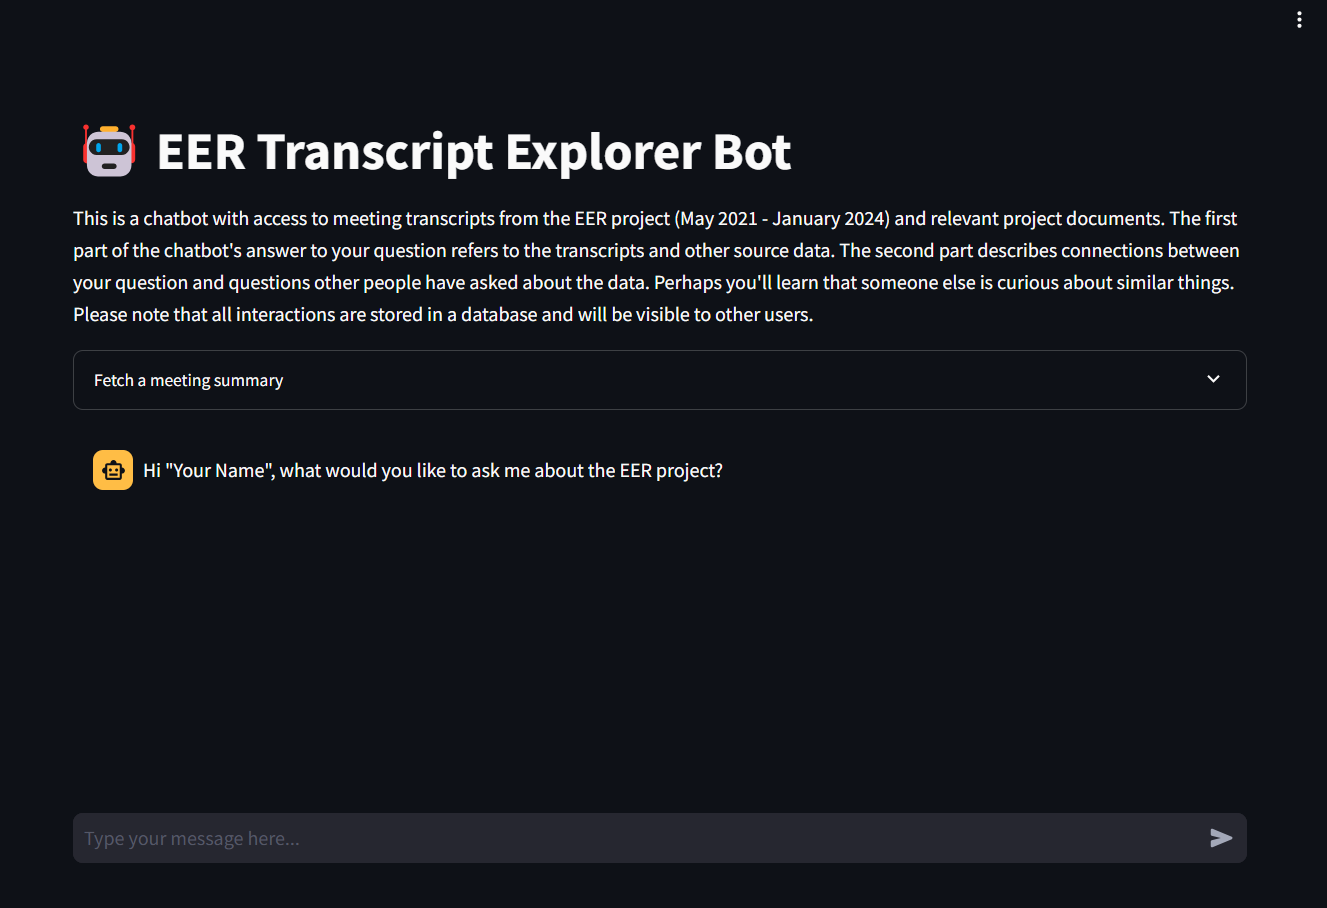

## Fetch a meeting feature
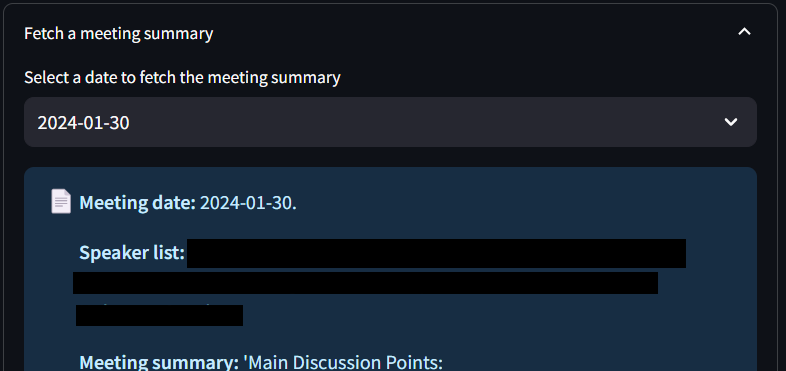

## Referenced data feature
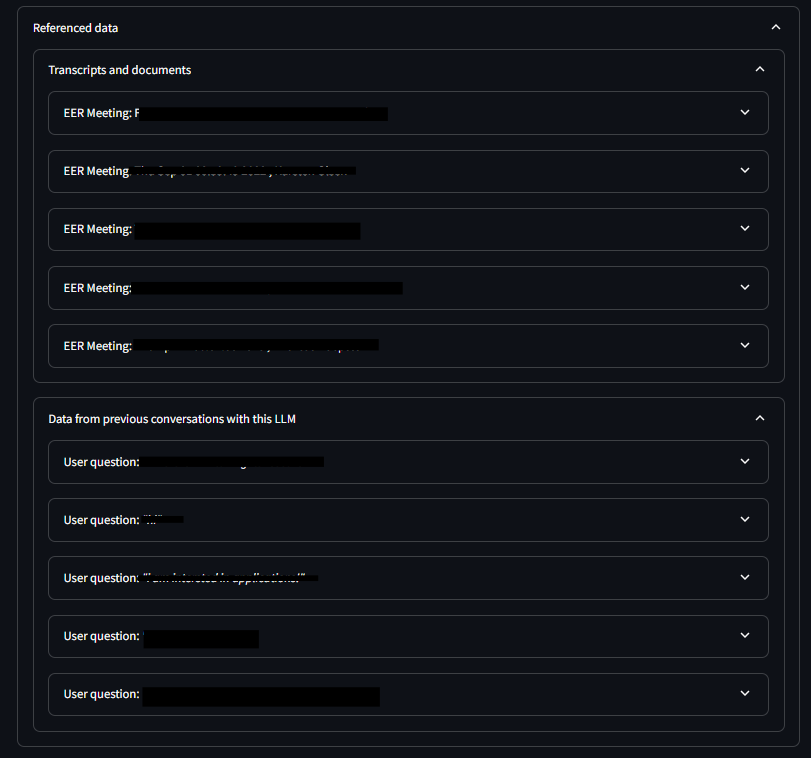